# Variant 4 - ConveRT Embedding type - Tensorflow 1 required

In [26]:
# Required Software - Tensorflow 1 needed
!pip install tensorflow-gpu==1.14.0
!pip install --no-deps tensorflow_text==0.1.0
!pip install tensorflow_hub
!pip install tensorflow-text

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [27]:
# Import the required dependencies
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_text  # required for tokenization ops
sess = None
import tensorflow as tf
sess = None
if sess is not None:
    sess.close()
sess = tf.InteractiveSession(graph=tf.Graph())

# Initializing ConveRT
module = tfhub.Module("http://models.poly-ai.com/convert/v1/model.tar.gz")
text_placeholder = tf.placeholder(dtype=tf.string, shape=[None])
encoding_tensor = module(text_placeholder)
encoding_dim = int(encoding_tensor.shape[1])
print(f"ConveRT encodes text to {encoding_dim}-dimensional vectors")
sess.run(tf.tables_initializer())
sess.run(tf.global_variables_initializer())

# Encode function of ConveRT
def encode(texts):
    """Encode the given texts to the encoding space."""
    return sess.run(encoding_tensor, feed_dict={text_placeholder: texts})

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ConveRT encodes text to 1024-dimensional vectors


In [28]:
########### Euclidean distance and ConveRT sample test to check quality of embeddings using distance concept ###########
encodings1 = encode(["im  hungry now"])
encodings2 = encode(["what music you like to hear"])
distance = np.linalg.norm(encodings1[0] - encodings2[0])
print(distance)

encodings3 = encode(["im  hungry now"])
encodings4 = encode(["What food you want to have"])
diff = np.power(encodings3[0] - encodings4[0],2)
distance = diff/np.linalg.norm(diff)
print(sum(distance))

41.32888
18.571025562055013


In [29]:
# PAckages needed for data preparation and modelling

!pip install pandasql
import pandasql as ps
import tensorflow as tf
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, SpatialDropout1D,Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,SimpleRNN,concatenate,Flatten,MaxPooling1D
from tensorflow.keras.models import Model
from keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow import keras
import nltk

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


# Data Preparation

In [30]:
#Dataset load and headers
X_Y_full = pd.read_excel('confusion_excel_800.xlsx', sheet_name='Sheet1')
del X_Y_full['Unnamed: 1']
del X_Y_full['Unnamed: 3']
del X_Y_full['Unnamed: 5']
X_Y_full.columns = ['request','response','confusion']
X_Y_full = X_Y_full[X_Y_full['request'].notnull()]
X_Y_full = X_Y_full[X_Y_full['response'].notnull()]
nltk.download('wordnet')

# Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    listToStr = ' '.join(map(str, [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]))
    return listToStr
X_Y_full['request'] = X_Y_full['request'].apply(lemmatize_text)
X_Y_full['response'] = X_Y_full['response'].apply(lemmatize_text)

# Stop Words Removal
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
X_Y_full = X_Y_full[X_Y_full['request'].notnull()]
X_Y_full = X_Y_full[X_Y_full['response'].notnull()]
X_Y_full['request'] = X_Y_full['request'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_Y_full['response'] = X_Y_full['response'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
X_Y_full['request']  = X_Y_full['request'].str.lower().str.strip()
X_Y_full['response']  = X_Y_full['response'].str.lower().str.strip()
X_Y_full['confusion'] = X_Y_full['confusion'].str.lower().str.strip()

# Loading Human 2 labelled dataset
X_Y_full_HS = pd.read_csv('Human_score.txt')
X_Y_full['HS'] = X_Y_full_HS['confusion']

# Data Splitting
train, validate,test = np.split(X_Y_full.sample(frac=1).reset_index(drop=True), [int(.8*len(X_Y_full)), int(0.9*len(X_Y_full))])
x_train_request = (train.request)
x_train_response = (train.response)
y_train = (train.confusion)
x_validate_request = (validate.request)
x_validate_response = (validate.response)
y_validate = (validate.confusion)
x_test_request = (test.request )
x_test_response = (test.response )
y_test = (test.confusion)
# Data Splitting - Human 2 labels
train_HS = train.HS
validate_HS = validate.HS
test_HS = test.HS


#Convert target to 0 and 1 and do numpy transformations to leverage fast parallel processing
y_train_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from train")
y_test_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from test")
y_validation_new = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from validate")
y_train_new = np.asarray(y_train_new['confusion_new'])
y_test_new = np.asarray(y_test_new['confusion_new'])
y_validation_new = np.asarray(y_validation_new['confusion_new'])
train_HS_new = np.asarray(train_HS)
validate_HS_new = np.asarray(validate_HS)
test_HS_new = np.asarray(test_HS)
y_full = ps.sqldf("select case when lower(confusion)='yes' then 1 else 0 end as confusion_new from X_Y_full")
act_y = np.asarray(y_full['confusion_new'])
pred = np.asarray(X_Y_full['HS'])



[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Evaluation - human 2 vs human 1 labelling - Base line performance 

[[400  18]
 [ 51 333]]
Accuracy: 0.913965
Precision: 0.948718
Recall: 0.867188
F1 score: 0.906122


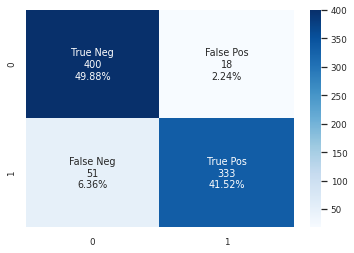

In [31]:

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
#Get the confusion matrix
cf_matrix = confusion_matrix(act_y, pred)
print(cf_matrix)

import seaborn as sns
#sns.heatmap(cf_matrix, annot=True)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(act_y, pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(act_y, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(act_y, pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(act_y, pred)
print('F1 score: %f' % f1)

# Cohen-kappa consistency check between human 2 and human 1

# 0.827 - Perfect Consistency

In [32]:

from sklearn.metrics import confusion_matrix, cohen_kappa_score
confusion_matrix(act_y, pred)
cohen_kappa_score(act_y, pred)

0.8270157735806591

In [33]:
# Encoding training sequences into conveRT's 1024 dimensional vectors using encode() function
row = 0
#import Math
list_res = list(x_train_response)
req_res_array = np.empty((0, 1024), float)
for j in x_train_request:
    req = encode([j])[0]
    res = encode([list_res[row]])[0]
    dif = np.asarray((req - res))
    #print(dif)
    distance = np.power(dif,2)
    
    XNormed = distance/np.linalg.norm(distance)
    #print(XNormed)
    #to_append = np. array(distance)
    req_res_array = np.append(req_res_array, [np.asarray(XNormed)],axis=0)
    row = row+1
    
# Encoding validation sequences into conveRT's 1024 dimensional vectors using encode() function
row_valid = 0
list_res_valid = list(x_validate_response)
req_res_array_valid = np.empty((0, 1024), float)
for j in x_validate_request:
    req_valid = encode([j])[0]
    res_valid = encode([list_res_valid[row_valid]])[0]
    dif_valid = np.asarray((req_valid - res_valid))
    #print(dif)
    distance_valid = np.power(dif_valid,2)
    XNormed_valid = distance_valid/np.linalg.norm(distance_valid)
    #print(XNormed)
    #to_append = np. array(distance)
    req_res_array_valid = np.append(req_res_array_valid, [np.asarray(XNormed_valid)],axis=0)
    row_valid = row_valid+1


# Encoding test sequences into conveRT's 1024 dimensional vectors using encode() function
row_test = 0
#import Math
list_res_test = list(x_test_response)
req_res_array_test = np.empty((0, 1024), float)
for j in x_test_request:
    req_test = encode([j])[0]
    res_test = encode([list_res_test[row_test]])[0]
    dif_test = np.asarray((req_test - res_test))
    #print(dif)
    distance_test = np.power(dif_test,2)
    XNormed_test = distance_test/np.linalg.norm(distance_test)
    #print(XNormed)
    #to_append = np. array(distance)
    req_res_array_test = np.append(req_res_array_test, [np.asarray(XNormed_test)],axis=0)
    row_test = row_test+1

# Modelling Variant 4

In [34]:
#initial model training, hyper parameter tuning
model = Sequential()
#model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(256,input_dim=1024,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.05), bias_regularizer=l2(0.01)))
model.add(Dense(10,activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1,activation='sigmoid'))
#model.summary()

#Loss Function # tried different values for learning_rate
from tensorflow.keras import optimizers
from tensorflow import keras
AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=AD,
              loss='binary_crossentropy',
              metrics=[keras.metrics.Recall(),keras.metrics.Precision(),'accuracy'])

#Training LSTM model
hist = model.fit(req_res_array, y_train_new,
          batch_size=10,
          epochs=20,verbose=1,validation_data=(req_res_array_valid, y_validation_new)
          )

Train on 641 samples, validate on 80 samples
Epoch 1/20
641/641 [==============================] - 1s 1ms/sample - loss: 1.7079 - recall: 0.5752 - precision: 0.5101 - acc: 0.5335 - val_loss: 1.1345 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.4750
Epoch 2/20
641/641 [==============================] - 0s 228us/sample - loss: 0.9043 - recall: 0.3203 - precision: 0.6447 - acc: 0.5913 - val_loss: 0.7675 - val_recall: 1.0000 - val_precision: 0.5753 - val_acc: 0.6125
Epoch 3/20
641/641 [==============================] - 0s 214us/sample - loss: 0.6918 - recall: 0.6013 - precision: 0.6815 - acc: 0.6755 - val_loss: 0.6643 - val_recall: 0.9286 - val_precision: 0.6842 - val_acc: 0.7375
Epoch 4/20
641/641 [==============================] - 0s 213us/sample - loss: 0.5970 - recall: 0.6601 - precision: 0.7240 - acc: 0.7176 - val_loss: 0.6086 - val_recall: 0.8571 - val_precision: 0.7347 - val_acc: 0.7625
Epoch 5/20
641/641 [==============================] - 0s 213us/sample - loss:

641/641 [==============================] - 0s 52us/sample
                      request                           response confusion  \
0    i met accident last week        i love watching soccer game       yes   
1     i think i'm good singer  learn play music practice singing        no   
2                      living       im professional chess master        no   
3     i love play mouth organ              yesterday i saw theif       yes   
4      understanding one time                        i sure mean       yes   
..                        ...                                ...       ...   
797                       job       i fix classic mustang living        no   
798                 old aunty    yesterday i saw cat video funny       yes   
799                     tired            im tired i got back gym        no   
800                       gym               i work grocery store       yes   
801               are testing                    no, i like eat.       yes   

     

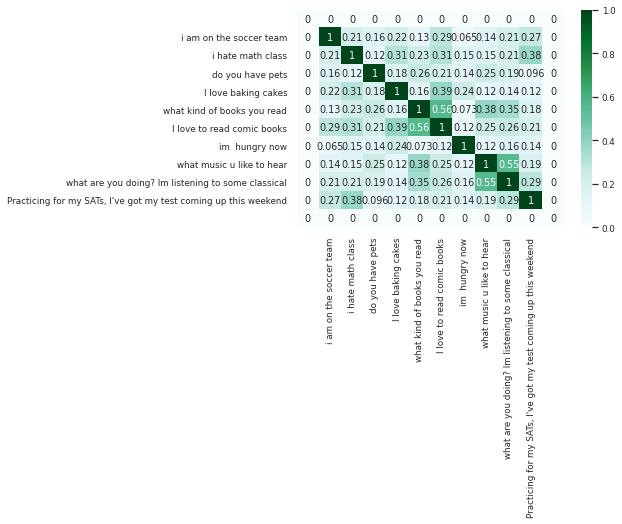

In [35]:
# variant 4 vs convert original similarity score comparison.
# the probability scores are written to a file and compared against the similarity scores of conveRT embedding vectors
# This comparison of prob scores in the file and the similarity score in the matrix is done manually based upon the samples chosen for comparison.

frames = [train, validate, test]

result = pd.concat(frames)

y_pred_whole=model.predict(inputs,batch_size=10,verbose = 1)

result['pred'] = y_pred_whole

result['pred_reverse'] = 1-result['pred']

result.to_csv("result_out.csv")

y_pred=model.predict(req_res_array,batch_size=10,verbose = 1)

print(result)

#ConveRT similarity score and model's probability score comparison
import numpy as np
from sklearn.metrics import pairwise
import seaborn
sample = (["i am on the soccer team",
           "i hate math class",
           "do you have pets",
           "I love baking cakes",
           "what kind of books you read",
           "I love to read comic books",
          "im  hungry now",
          "what music u like to hear",
          "what are you doing? Im listening to some classical",
           "Practicing for my SATs, I've got my test coming up this weekend"
])
texts = [""] + sample + [""]


encodings = encode(texts)

similarities = pairwise.cosine_similarity(encodings)
seaborn.set(font_scale=0.8)
g = seaborn.heatmap(
    similarities,
    xticklabels=texts,
    yticklabels=texts,
    vmin=1.,
    vmax=0.,
    cmap="BuGn",
    square=False,
    annot = True
)



# Evaluation of Variant 4 - 10-fold validation

In [42]:

from sklearn.model_selection import KFold
import numpy as np
num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
rec_per_fold = []
per_per_fold = []
acc_per_fold_HS=[]
rec_per_fold_HS=[]


inputs = np.concatenate((req_res_array, req_res_array_valid, req_res_array_test), axis=0)
targets = np.concatenate((y_train_new, y_validation_new,y_test_new), axis=0)
HS_ = np.concatenate((train_HS_new, validate_HS_new,test_HS_new), axis=0)

from tensorflow import keras
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers


kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(inputs, targets,HS_):
    model = Sequential()
    #model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(256,input_dim=1024,activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(20,activation='relu',kernel_regularizer=l2(0.05), bias_regularizer=l2(0.01)))
    model.add(Dense(10,activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(1,activation='sigmoid'))
    #model.summary()
    
    AD = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=AD,
                  loss='binary_crossentropy',
                  metrics=[ keras.metrics.Recall(),'accuracy',keras.metrics.Precision()])
    

    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    #Training LSTM model
    history = model.fit(inputs[train], targets[train],
          batch_size=10,
          epochs=20,verbose=1
          )



    #Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}% ; {model.metrics_names[2]} of {scores[2]*100}%')
    acc_per_fold.append(scores[2] * 100)
    loss_per_fold.append(scores[0])
    rec_per_fold.append(scores[1])
    per_per_fold.append(scores[3])

    # Increase fold number
    fold_no = fold_no + 1
    
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(targets[test], HS_[test])
    print('Accuracy_HS: %f' % accuracy)
    # precision tp / (tp + fp)
    #precision = precision_score(act_y, pred_HS)
    #print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(targets[test], HS_[test])
    print('Recall_HS: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    #f1 = f1_score(act_y, pred)
    #print('F1 score: %f' % f1)
    acc_per_fold_HS.append(accuracy)
    rec_per_fold_HS.append(recall)
    

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%  - Recall: {rec_per_fold[i]}% - Precision: {per_per_fold[i]}%')
  #print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy_HS: {acc_per_fold_HS[i]}%  - Recall: {rec_per_fold_HS[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Recall: {np.mean(rec_per_fold)} (+- {np.std(rec_per_fold)})')
print(f'> Precision: {np.mean(per_per_fold)} (+- {np.std(per_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
print(f'> Accuracy_HS: {np.mean(acc_per_fold_HS)} (+- {np.std(acc_per_fold_HS)})')
print(f'> Recall_HS: {np.mean(rec_per_fold_HS)} (+- {np.std(rec_per_fold_HS)})')
#print(f'> Loss: {np.mean(loss_per_fold)}')






------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
721/721 [==============================] - 1s 703us/sample - loss: 1.6302 - recall_11: 0.4519 - acc: 0.5395 - precision_11: 0.5184
Epoch 2/20
721/721 [==============================] - 0s 229us/sample - loss: 0.8264 - recall_11: 0.5131 - acc: 0.6574 - precision_11: 0.6875
Epoch 3/20
721/721 [==============================] - 0s 217us/sample - loss: 0.6217 - recall_11: 0.7376 - acc: 0.7406 - precision_11: 0.7229
Epoch 4/20
721/721 [==============================] - 0s 218us/sample - loss: 0.5100 - recall_11: 0.8105 - acc: 0.7989 - precision_11: 0.7765
Epoch 5/20
721/721 [==============================] - 0s 217us/sample - loss: 0.4954 - recall_11: 0.7988 - acc: 0.8183 - precision_11: 0.8155
Epoch 6/20
721/721 [==============================] - 0s 219us/sample - loss: 0.4084 - recall_11: 0.8659 - acc: 0.8544 - precision_11: 0.8343
Epoch 7/20
721/721 [==============================]

In [43]:
#Accuracy list for variant 4
acc_per_fold

round_to_tenths = [round(num, 2) for num in acc_per_fold]
print(round_to_tenths)
print(np.mean(round_to_tenths))
print(np.std(round_to_tenths))

[67.9, 75.31, 67.5, 73.75, 77.5, 75.0, 73.75, 73.75, 77.5, 80.0]
74.196
3.7746448839592834


In [44]:
#Recall list for variant 4
rec_per_fold

round_to_tenths_rec = [round(num*100, 2) for num in rec_per_fold]
print(round_to_tenths_rec)
print(np.mean(round_to_tenths_rec))
print(np.std(round_to_tenths_rec))

[63.41, 66.67, 57.89, 70.73, 79.41, 81.08, 82.86, 70.27, 82.05, 79.07]
73.34399999999998
8.331344669379607


In [39]:
#Recall for baseline pweformance
rec_per_fold_HS

round_to_tenths_rec_HS = [round(num*100, 2) for num in rec_per_fold_HS]
print(round_to_tenths_rec_HS)
print(np.mean(round_to_tenths_rec_HS))
print(np.std(round_to_tenths_rec_HS))

[85.0, 90.24, 97.06, 85.29, 82.93, 87.5, 88.1, 87.18, 86.05, 76.67]
86.602
4.926560260465712


In [45]:
#Normality Test
import scipy
from scipy import stats
pts = 10
np.random.seed(28041990)
#[66,64,82,80,80,91,87,76,81,69]
a = round_to_tenths_rec_HS
b = round_to_tenths_rec

# Shapiro-Wilk Test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = a
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

# generate univariate observations
data = b
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.937, p=0.525
Sample looks Gaussian (fail to reject H0)
Statistics=0.901, p=0.223
Sample looks Gaussian (fail to reject H0)


# H1 Rejected H0 Accepted

In [46]:
#T-test Result
twosample_results = scipy.stats.ttest_ind(a,b)
twosample_results

Ttest_indResult(statistic=4.1093250645861055, pvalue=0.0006584191551897072)